# load KCWI measurements

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data, header = fits.getdata('../kcwi_extractions/extracted_dispersions/'
                            'KCWI_RXJ1131_icubes_mosaic_0.1457_crop.fits', header=True)

#data_no_quasar = np.empty_like(data_crop[0].data)
#noise_cube = np.empty_like(data_crop[0].data)

# data = np.loadtxt('../kcwi_extractions/extracted_dispersions'
#                    '/KCWI_RXJ1131_icubes_mosaic_0.1457_total.txt')

In [3]:
noise, header = fits.getdata('../kcwi_extractions/extracted_dispersions'
                         '/KCWI_RXJ1131_icubes_mosaic_0.1457_noise.fits', header=True)
# noise = np.loadtxt('../kcwi_extractions/extracted_dispersions'
#                    '/KCWI_RXJ1131_icubes_mosaic_0.1457_total_noise.txt')
#np.ones_like(data) * 0.014

In [4]:
data.shape, noise.shape

((5215, 43, 43), (5215, 43, 43))

In [5]:
import sys
sys.path.append("/Users/ajshajib/Research/RXJ1131_KCWI/kcwi_extractions/")

from kcwi_util_modified import *

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


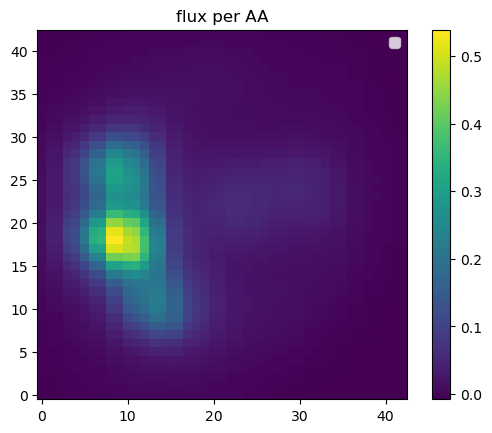

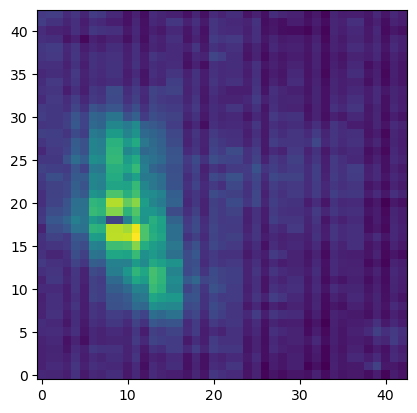

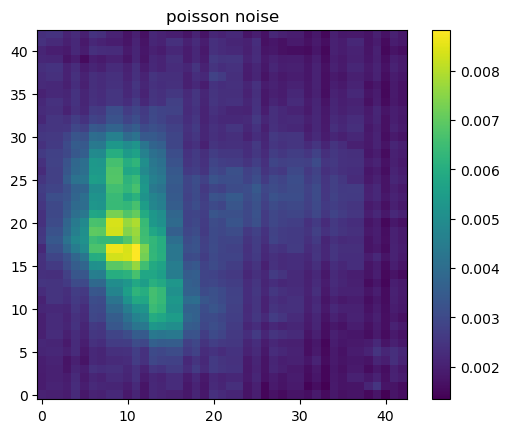

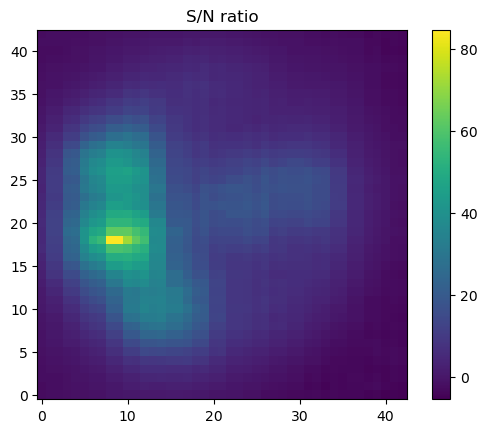

In [6]:
SN_per_AA, flux_per_AA, sigma_poisson = SN_CaHK(3663, 3922, data, noise,
                                                15960);

In [7]:
data_2d = flux_per_AA #np.sum(data, axis=0)
noise_2d = sigma_poisson #np.sqrt(np.sum((noise)**2, axis=0))

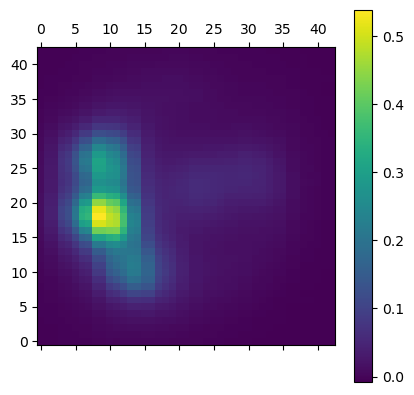

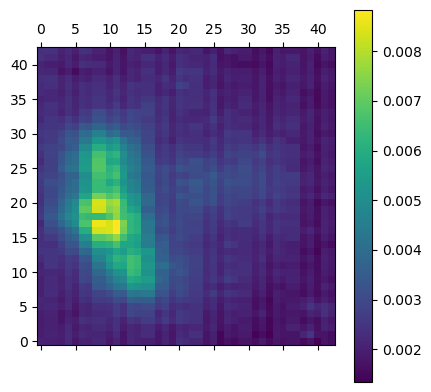

In [8]:
cbar = plt.matshow(data_2d, origin='lower')
plt.colorbar(cbar)
plt.show()

cbar = plt.matshow(noise_2d, origin='lower')
plt.colorbar(cbar)

In [9]:
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util.param_util import phi_q2_ellipticity
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# make mask for fitting

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1281583963.py:27: RuntimeWarning: divide by zero encountered in log10
  cbar = plt.matshow(np.log10(data_2d * mask), origin='lower')


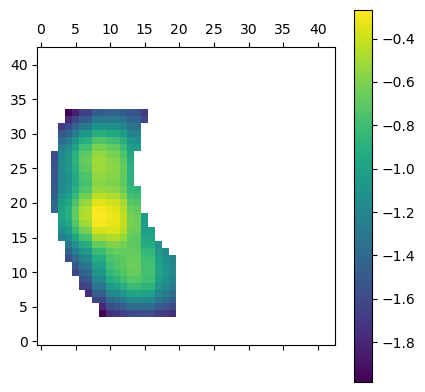

In [23]:
from scipy.ndimage import binary_erosion
    
pixel_size = 0.1457

# arcsecond grid is used for making mask
x, y = np.meshgrid(np.arange(-3.0597, 3.1597, pixel_size),
                   np.arange(-3.0597, 3.1597, pixel_size))


mask = np.ones_like(x)
mask[data_2d <= 0] = 0

mask[((x - 0.2914)**2 + (y - 0.2914)**2) > 12] = 0.

mask[((x - 1.2914)**2 + (y - .2914)**2) > 17] = 0.

mask[((x + 1.2914)**2 + (y + .2914)**2) > 6] = 0.

mask[((x - 1.5914)**2 + (y - .5914)**2) < 7] = 0.

mask[:4, :] = 0
mask[34:, :] = 0
mask[:, 20:] = 0
# for i in range(1):
#     mask = binary_erosion(mask)

cbar = plt.matshow(np.log10(data_2d * mask), origin='lower')
plt.colorbar(cbar)

In [24]:
xs, ys = np.meshgrid(np.arange(43), np.arange(43))

def get_gauss_profile(x, y, x_0, y_0, sigma, amp=1):
    """

    """
    return amp / (2 * np.pi * sigma**2) * np.exp(-((x-x_0)**2 + (y-y_0)**2) / 2. / sigma**2)


light_model = LightModel(['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])

# R_sersic_1 = lambda _: np.random.normal(2.37, 0.01) * 0.912 #np.sqrt(
#                                         #np.random.normal(0.912, 0.004))
# n_sersic_1 = lambda _: np.random.normal(0.63, 0.01)
# I_light_1 = lambda _: np.random.normal(1.47, 0.02)
# q_light_1 = lambda _: 0.921 #np.random.normal(0.921, 0.004)
# phi_light_1 = lambda _: 90 - 116.9 # np.random.normal(90-116.9, 0.4)

# R_sersic_2 = lambda _: np.random.normal(0.404, 0.005) * 0.867 #np.sqrt(
#                                     #np.random.normal(0.867, 0.002))
# n_sersic_2 = lambda _: np.random.normal(1.97, 0.02)
# I_light_2 = lambda _: np.random.normal(18.1, 0.3)
# q_light_2 = lambda _: 0.867 #np.random.normal(0.867, 0.002
    
    
e11, e12 = phi_q2_ellipticity(116.9, 0.921)
e21, e22 = phi_q2_ellipticity(116.9, 0.867)
kwargs_light = [{'R_sersic': 2.37, 'n_sersic': 0.63, 'amp': 1.47, 'e1': e11, 'e2': e12},
                {'R_sersic': 0.404, 'n_sersic': 1.97, 'amp': 18.1, 'e1': e21, 'e2': e22},
               ]

def get_sersic_profile(x, y, x_0, y_0):
    """
    """
    kwargs_light[0]['center_x'] = x_0
    kwargs_light[0]['center_y'] = y_0
    kwargs_light[1]['center_x'] = x_0
    kwargs_light[1]['center_y'] = y_0
    
    return light_model.surface_brightness(x, y, kwargs_light)


sigma = 0.7/2.355/pixel_size
kernel = Gaussian2DKernel(x_stddev=sigma,
                          x_size=4*int(sigma)+1,
                          y_size=4*int(sigma)+1)

ras = np.array([2.383, 2.344, 2.960, 5.494]) - 2.383 #4.420
decs = np.array([3.412, 4.594, 2.300, 4.288]) - 3.412 #3.932
ras /= pixel_size
decs /= pixel_size
amps = np.array([21880, 38555, 11565, 3215])


def get_light_models(x_0, y_0, sigma=sigma):
    """
    """
    light_models = [] #np.zeros_like(x)
    
    for r, d, a in zip(ras, decs, amps):
        light_models.append((get_gauss_profile(xs, ys, r+x_0, d+y_0, sigma,
                                               a)*mask).flatten())
        
    #light_models.append((convolve(get_sersic_profile(x, y, x_0, y_0),
    # kernel)*mask).flatten())
    
    light_models = np.array(light_models)
    
    return light_models
    
    
# noise = 0.5 * data

# weight = (1./noise.flatten())
# sqrt_weight_matrix = np.zeros((len(weight), len(weight)))
# np.fill_diagonal(sqrt_weight_matrix, np.sqrt(weight))

# weighted_data = data.flatten() * np.sqrt(weight) #tf.expand_dims(tf.constant(data * np.sqrt(weight), dtype=const.TFLOAT), axis=1) # inverse-variance weighted data
weighted_data = data_2d.flatten()


def get_full_light_model(x_0, y_0, sigma):
    """
    """
    light_models = get_light_models(x_0, y_0, sigma)

    A = light_models.T
#     A_weighted = sqrt_weight_matrix @ A
#     S, U, V = np.linalg.svd(A_weighted)
#     T = np.linalg.diag(1./S) @ np.transpose(U)
#     x = (V @ T) @ b
        
    coeffs = np.linalg.lstsq(A, weighted_data)[0]
    
    light_model = light_models.T @ coeffs
    
    return light_model.reshape(xs.shape)

In [25]:
decs

array([ 0.        ,  8.11256005, -7.6321208 ,  6.01235415])

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1889218424.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(A, weighted_data)[0]
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/3834143273.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(get_full_light_model(9, 18, 1)), origin='lower')


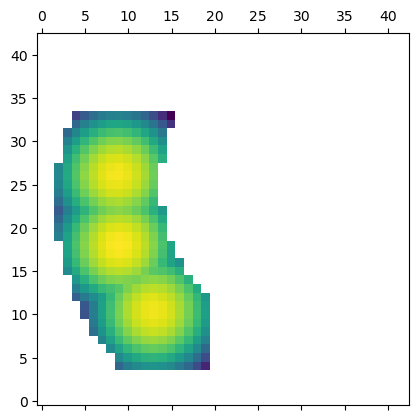

In [26]:
plt.matshow(np.log10(get_full_light_model(9, 18, 1)), origin='lower')

In [27]:
x_0_guess, y_0_guess = 9, 18

def log_probability(params):
    """
    """
    x_0, y_0 = params
    sigma_0 = 0.98 / 2.355 / pixel_size

    if not (x_0_guess-2 < x_0 < x_0_guess+2) \
            or not (y_0_guess-2 < y_0 < y_0_guess+2) \
            or not (0 < sigma_0 < 5):
        return -np.inf
    
    light_model = get_full_light_model(x_0, y_0, sigma_0)
    
    log_prob = -0.5 * np.sum(((data_2d - light_model)**2/noise_2d) * mask)

    if np.isnan(log_prob):
        return -np.inf
    elif np.isinf(log_prob):
        return -np.inf
    else:
        return log_prob


In [28]:
log_probability([9, 18]) / np.sum(mask) * 1

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1889218424.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(A, weighted_data)[0]


-0.07246248760084256

In [29]:
import emcee

In [30]:
nwalkers, ndim = 300, 2
init_pos = np.random.normal(loc=[x_0_guess, y_0_guess],
                       scale=0.1, size=(nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

sampler.run_mcmc(init_pos, 500, progress=True);


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1889218424.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(A, weighted_data)[0]
100%|██████████| 500/500 [00:22<00:00, 21.87it/s]


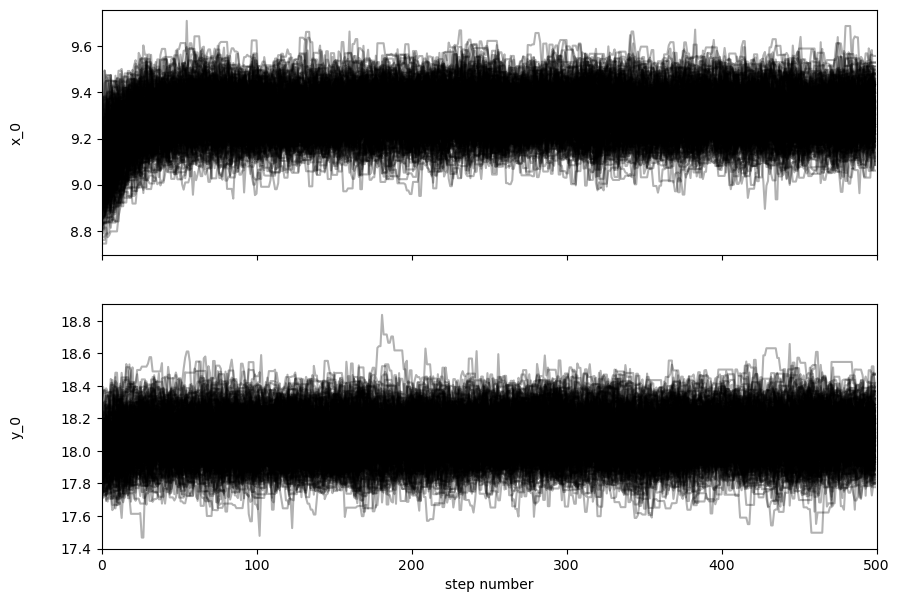

In [31]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["x_0", "y_0" , "sigma"][:ndim]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [32]:
x_0, y_0 = np.median(samples[-200::20, :, :].reshape(-1, ndim),
                              axis=0)

x_0, y_0

(9.303747459002246, 18.093803669328295)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1889218424.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(A, weighted_data)[0]


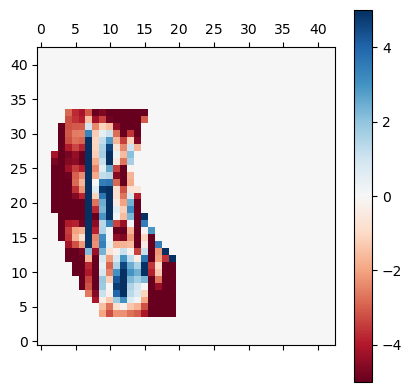

In [33]:
sigma = 0.98 / 2.355 / pixel_size

plt.matshow(((get_full_light_model(x_0, y_0, sigma) - data_2d) /
             (noise_2d)
             )*mask, origin='lower', cmap='RdBu', vmax=5, vmin=-5)
plt.colorbar()

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/1889218424.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(A, weighted_data)[0]
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/621768597.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10((get_full_light_model(x_0, y_0, sigma))),


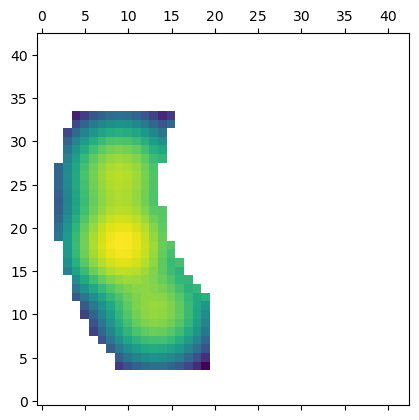

In [34]:
plt.matshow(np.log10((get_full_light_model(x_0, y_0, sigma))),
            origin='lower')

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_24468/4266222133.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(data_2d*mask), origin='lower')


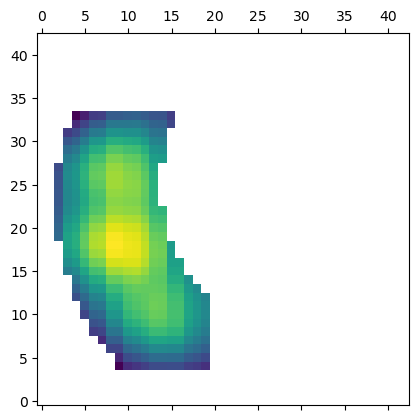

In [35]:
plt.matshow(np.log10(data_2d*mask), origin='lower')

In [36]:
delta_x = (2.383 - 4.411) / pixel_size
delta_y = (3.412 - 4.011) / pixel_size

In [37]:
x_0 - delta_x, y_0 - delta_y

(23.22275912681281, 22.20499104063921)

In [38]:
delta_x_s = (2.383 - 4.323) / pixel_size
delta_y_s = (3.412 - 4.546) / pixel_size

x_0 - delta_x_s, y_0 - delta_y_s

(22.618778344383166, 25.876919661092195)

In [39]:
x_0 + ras, y_0 + decs

(array([ 9.30374746,  9.03607416, 13.26393963, 30.6558408 ]),
 array([18.09380367, 26.20636372, 10.46168287, 24.10615782]))